## Lung cancer prediction
This notebook contains the steps in the development of a machine learning model that clusters different types of histology tags of lung cancer

In [185]:
#import the necesary libraries
import requests
import numpy as np
import pandas as pd
import gzip
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [186]:
#load in the clinical dataset
url = "https://wiki.cancerimagingarchive.net/download/attachments/16056856/Lung3.metadata.xls?version=1&modificationDate=1404237338168&api=v2"
s = requests.get(url).content
clinical_data = pd.read_excel(s)

In [187]:
#inspect the data
clinical_data

,sample.name,title,CEL.file,source.location,organism,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.primaryVSmets,characteristics.tag.grade,molecule tested,label,platform
0,LUNG3-01,lung_1,LUNG3-01.CEL,Left Lower Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, NOS",4.0,pT2,pN0,pM0,Primary,3,total RNA,biotin,GPL15048
1,LUNG3-02,lung_2,LUNG3-02.CEL,Left Lower Lobe,Homo sapiens,M,"Adenocarcinoma, Papillary, NOS",1.3,pT1,pNX,pMX,Primary,Not Available,total RNA,biotin,GPL15048
2,LUNG3-03,lung_3,LUNG3-03.CEL,Left Lower Lobe,Homo sapiens,M,Non-Small Cell,11.0,pT3,pN0,pM0,Primary,3,total RNA,biotin,GPL15048
3,LUNG3-04,lung_4,LUNG3-04.CEL,Left Lower Lobe,Homo sapiens,M,"Papillary Type AND Adenocarcinoma, Bronch...",NaN,pTX,pNx,pM1,Primary,Not Available,total RNA,biotin,GPL15048
4,LUNG3-05,lung_5,LUNG3-05.CEL,Left Lower Lobe,Homo sapiens,F,"Squamous Cell Carcinoma, NOS",7.8,pT3,pN0,pM0,Primary,2,total RNA,biotin,GPL15048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,LUNG3-85,lung_85,LUNG3-85.CEL,Right Upper Lobe,Homo sapiens,M,"Adenocarcinoma, Acinar Type",2.2,pT1b,pN0,pM0,Primary,Not Available,total RNA,biotin,GPL15048
85,LUNG3-86,lung_86,LUNG3-86.CEL,Right Upper Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, NOS",5.0,pT3,PN2,pM0,Primary,3,total RNA,biotin,GPL15048
86,LUNG3-87,lung_87,LUNG3-87.CEL,Right Middle Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, Papillary",3.5,pT2,pN0,pM0,Primary,2,total RNA,biotin,GPL15048
87,LUNG3-88,lung_88,LUNG3-88.CEL,Right Upper Lobe,Homo sapiens,M,"Non-Small Cell, Pleomorphic Type",8.5,pT3,pN0,pM0,Primary,Not Available,total RNA,biotin,GPL15048


## Exploratory data analysis on Clinical Data

In [188]:
#get a quick statistics
clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 16 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   sample.name                                     89 non-null     object 
 1   title                                           89 non-null     object 
 2   CEL.file                                        89 non-null     object 
 3   source.location                                 89 non-null     object 
 4   organism                                        89 non-null     object 
 5   characteristics.tag.gender                      89 non-null     object 
 6   characteristics.tag.histology                   89 non-null     object 
 7   characteristics.tag.tumor.size.maximumdiameter  88 non-null     float64
 8   characteristics.tag.stage.primary.tumor         89 non-null     object 
 9   characteristics.tag.stage.nodes              

In [189]:
#create a function to return a list of columns with a only one value
def filter_singlevalue(dataframe):
    columns = list(clinical_data.columns)
    for col in columns:
        if len(dataframe[col].unique()) == 1 : #get columns that have the same value for all rows
            print(col)

In [190]:
filter_singlevalue(clinical_data)

organism
characteristics.tag.primaryVSmets
molecule tested
label
platform


In [191]:
#drop the columns
clinical_data = clinical_data.drop(columns=['organism', 'characteristics.tag.primaryVSmets','molecule tested' ,
                                          'label', 'platform'], axis= 1)
clinical_data

,sample.name,title,CEL.file,source.location,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.grade
0,LUNG3-01,lung_1,LUNG3-01.CEL,Left Lower Lobe,M,"Squamous Cell Carcinoma, NOS",4.0,pT2,pN0,pM0,3
1,LUNG3-02,lung_2,LUNG3-02.CEL,Left Lower Lobe,M,"Adenocarcinoma, Papillary, NOS",1.3,pT1,pNX,pMX,Not Available
2,LUNG3-03,lung_3,LUNG3-03.CEL,Left Lower Lobe,M,Non-Small Cell,11.0,pT3,pN0,pM0,3
3,LUNG3-04,lung_4,LUNG3-04.CEL,Left Lower Lobe,M,"Papillary Type AND Adenocarcinoma, Bronch...",NaN,pTX,pNx,pM1,Not Available
4,LUNG3-05,lung_5,LUNG3-05.CEL,Left Lower Lobe,F,"Squamous Cell Carcinoma, NOS",7.8,pT3,pN0,pM0,2
...,...,...,...,...,...,...,...,...,...,...,...
84,LUNG3-85,lung_85,LUNG3-85.CEL,Right Upper Lobe,M,"Adenocarcinoma, Acinar Type",2.2,pT1b,pN0,pM0,Not Available
85,LUNG3-86,lung_86,LUNG3-86.CEL,Right Upper Lobe,M,"Squamous Cell Carcinoma, NOS",5.0,pT3,PN2,pM0,3
86,LUNG3-87,lung_87,LUNG3-87.CEL,Right Middle Lobe,M,"Squamous Cell Carcinoma, Papillary",3.5,pT2,pN0,pM0,2
87,LUNG3-88,lung_88,LUNG3-88.CEL,Right Upper Lobe,M,"Non-Small Cell, Pleomorphic Type",8.5,pT3,pN0,pM0,Not Available


In [192]:
#drop title and CEL.file since they are redundant
clinical_data = clinical_data.drop(columns= ['title', 'CEL.file'], axis=1)
clinical_data

,sample.name,source.location,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.grade
0,LUNG3-01,Left Lower Lobe,M,"Squamous Cell Carcinoma, NOS",4.0,pT2,pN0,pM0,3
1,LUNG3-02,Left Lower Lobe,M,"Adenocarcinoma, Papillary, NOS",1.3,pT1,pNX,pMX,Not Available
2,LUNG3-03,Left Lower Lobe,M,Non-Small Cell,11.0,pT3,pN0,pM0,3
3,LUNG3-04,Left Lower Lobe,M,"Papillary Type AND Adenocarcinoma, Bronch...",NaN,pTX,pNx,pM1,Not Available
4,LUNG3-05,Left Lower Lobe,F,"Squamous Cell Carcinoma, NOS",7.8,pT3,pN0,pM0,2
...,...,...,...,...,...,...,...,...,...
84,LUNG3-85,Right Upper Lobe,M,"Adenocarcinoma, Acinar Type",2.2,pT1b,pN0,pM0,Not Available
85,LUNG3-86,Right Upper Lobe,M,"Squamous Cell Carcinoma, NOS",5.0,pT3,PN2,pM0,3
86,LUNG3-87,Right Middle Lobe,M,"Squamous Cell Carcinoma, Papillary",3.5,pT2,pN0,pM0,2
87,LUNG3-88,Right Upper Lobe,M,"Non-Small Cell, Pleomorphic Type",8.5,pT3,pN0,pM0,Not Available


In [193]:
clinical_data['characteristics.tag.stage.primary.tumor'].unique()

array(['pT2', 'pT1', 'pT3', 'pTX', 'pT2b', 'pT4', 'pT1a', 'pT2a', 'pTx',
       'PT2', 'pT1b'], dtype=object)

In [194]:
clinical_data['characteristics.tag.grade'].unique()

array([3, 'Not Available', 2, 1, 4], dtype=object)

In [195]:
# replace not avalable tag grades with an in
clinical_data['characteristics.tag.grade'] = clinical_data['characteristics.tag.grade'].replace(['Not Available'],5)

In [196]:
#check the length different categories we will be prdicting
len(clinical_data['characteristics.tag.histology'].unique()) #there are 17 categories, this should be reduced

17

In [197]:
clinical_data['characteristics.tag.histology'].unique()

array(['Squamous Cell Carcinoma, NOS', 'Adenocarcinoma, Papillary, NOS',
       'Non-Small Cell',
       'Papillary Type AND \xa0\xa0\xa0\xa0 Adenocarcinoma, Bronchiolo-alveolar Features',
       'Adenocarcinoma, NOS', 'Solid Type And Acinar',
       'Adenocarcinoma, Mixed',
       'Adenocarcinoma, Mucinous With Bronchiolo-alveolar Features',
       'Adenocarcinoma, Acinar Type',
       'Squamous Cell Carcinoma, Other (Specify) with adeno features',
       'Adenocarcinoma With Mucinous Features',
       'Adenocarcinoma, Bronchiolo-alveolar Features',
       'Adenocarcinoma With Papillary Features',
       'Carcinoma, Large Cell, Neuroendocrine',
       'Squamous Cell Carcinoma, Other (Specify)endobronchial',
       'Squamous Cell Carcinoma, Papillary',
       'Non-Small Cell, Pleomorphic Type'], dtype=object)

In [198]:
clinical_data['characteristics.tag.histology'].value_counts()

Squamous Cell Carcinoma, NOS                                            33
Adenocarcinoma, NOS                                                     25
Non-Small Cell                                                           7
Adenocarcinoma, Papillary, NOS                                           4
Adenocarcinoma, Bronchiolo-alveolar Features                             4
Adenocarcinoma, Acinar Type                                              3
Solid Type And Acinar                                                    2
Adenocarcinoma With Papillary Features                                   2
Adenocarcinoma, Mixed                                                    1
Adenocarcinoma, Mucinous With Bronchiolo-alveolar Features               1
Squamous Cell Carcinoma, Other (Specify) with adeno features             1
Adenocarcinoma With Mucinous Features                                    1
Papillary Type AND      Adenocarcinoma, Bronchiolo-alveolar Features     1
Carcinoma, Large Cell, Ne

There are 17 groups, but a lot of them can be grouped together. 

In [199]:
def categorise(row):  
    if row['characteristics.tag.histology'] in ['Squamous Cell Carcinoma, NOS', 'Squamous Cell Carcinoma, Other (Specify) with adeno features',
                                                'Squamous Cell Carcinoma, Other (Specify)endobronchial', 'Squamous Cell Carcinoma, Papillary'] : #group squamous cells together
        return 'Squamous Cell Carcinoma, NOS'
    elif row['characteristics.tag.histology']in ["Adenocarcinoma, NOS", 'Papillary Type AND      Adenocarcinoma, Bronchiolo-alveolar Features',
                                                 'Adenocarcinoma With Mucinous Features', 'Adenocarcinoma, Mucinous With Bronchiolo-alveolar Features',
                                                 'Adenocarcinoma, Mixed', 'Adenocarcinoma With Papillary Features',
                                                 'Adenocarcinoma, Acinar Type', 'Adenocarcinoma, Bronchiolo-alveolar Features', 'Adenocarcinoma, Papillary, NOS']: #group adenocarcinoma together
        return 'Adenocarcinoma, NOS'
    else: #put the rest as others
        return 'Others'
    

In [200]:
#apply the function
clinical_data['label'] = clinical_data.apply(lambda row: categorise(row), axis=1)

In [201]:

clinical_data['label'] = clinical_data['label'].map({'Squamous Cell Carcinoma, NOS':1,
                             'Adenocarcinoma, NOS':2,
                             'Others':3,
                             },
                             na_action=None)

In [202]:
#drop the characteristics.tag.histology column
clinical_data = clinical_data.drop('characteristics.tag.histology', axis=1)

In [203]:
clinical_data['characteristics.tag.stage.primary.tumor'].unique()

array(['pT2', 'pT1', 'pT3', 'pTX', 'pT2b', 'pT4', 'pT1a', 'pT2a', 'pTx',
       'PT2', 'pT1b'], dtype=object)

In [204]:
def relabel(row):  
    if row['characteristics.tag.stage.primary.tumor'] in ['pT2', 'PT2']:
        return 'pT2'
    elif row['characteristics.tag.stage.primary.tumor'] in ['pTX','pTx' ]:
        return 'pTX'
    else:
        return row['characteristics.tag.stage.primary.tumor']

In [205]:
#apply the function
clinical_data['characteristics.tag.stage.primary.tumor'] = clinical_data.apply(lambda row: relabel(row), axis=1)

In [206]:
clinical_data['characteristics.tag.stage.primary.tumor'].unique()

array(['pT2', 'pT1', 'pT3', 'pTX', 'pT2b', 'pT4', 'pT1a', 'pT2a', 'pT1b'],
      dtype=object)

In [207]:
clinical_data['characteristics.tag.stage.nodes'].unique()

array(['pN0', 'pNX', 'pNx', 'pN2', 'pN1', 'PN2'], dtype=object)

In [208]:
clinical_data['characteristics.tag.stage.nodes'].replace({'pNx': 'pNX', 'pN2': 'PN2'}, inplace=True)

In [209]:
#check for missing data
clinical_data.isnull().sum()

sample.name                                       0
source.location                                   0
characteristics.tag.gender                        0
characteristics.tag.tumor.size.maximumdiameter    1
characteristics.tag.stage.primary.tumor           0
characteristics.tag.stage.nodes                   0
characteristics.tag.stage.mets                    0
characteristics.tag.grade                         0
label                                             0
dtype: int64

# Exploratory Data Analysis of Gene Expression Data

In [210]:
#load data
url = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE58nnn/GSE58661/matrix/GSE58661_series_matrix.txt.gz'
g =  BytesIO(requests.get(url).content)
gene_data = pd.read_csv(g, compression='gzip', header=61, sep='\t', quotechar='"')

In [211]:
#inspect data
gene_data

,ID_REF,GSM1416528,GSM1416529,GSM1416530,GSM1416531,GSM1416532,GSM1416533,GSM1416534,GSM1416535,GSM1416536,...,GSM1416607,GSM1416608,GSM1416609,GSM1416610,GSM1416611,GSM1416612,GSM1416613,GSM1416614,GSM1416615,GSM1416616
0,AFFX-BioB-3_at,7.376915,8.024915,7.522543,7.152864,7.211031,7.704962,7.779374,7.136893,7.160221,...,7.611992,7.345206,7.316975,7.418340,7.756286,7.215856,7.465109,7.245458,7.039592,7.393667
1,AFFX-BioB-5_at,6.984530,7.427048,7.077207,6.849513,6.753131,7.195947,7.429800,6.745630,6.751358,...,7.175015,7.014479,6.913879,6.898449,7.347570,6.740992,7.080787,6.725812,6.575376,7.041106
2,AFFX-BioB-M_at,7.330576,8.010530,7.334551,7.143286,7.077163,7.753484,7.712429,7.036303,7.089186,...,7.612393,7.285821,7.324635,7.408880,7.745624,7.152722,7.422373,7.263596,6.975162,7.366620
3,AFFX-BioC-3_at,10.922741,11.390638,10.936703,10.791909,10.701328,11.221732,11.084229,10.588372,10.628909,...,11.097486,10.908682,10.781228,10.935723,11.200635,10.707980,10.736531,10.770440,10.367009,10.753221
4,AFFX-BioC-5_at,11.032030,11.533338,11.018510,10.875259,10.823792,11.276973,11.178643,10.700420,10.779332,...,11.265739,10.990373,10.900765,11.101546,11.343329,10.842697,10.900509,10.838008,10.494806,10.863600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60603,merck2-Z70222_a_at,6.892053,5.513603,6.112918,6.276813,7.041829,7.560786,7.446324,7.821045,7.465401,...,7.028523,6.229570,7.543618,7.518894,6.541189,6.493021,7.952822,6.978308,7.460604,7.519374
60604,merck2-Z70608_x_at,1.777216,1.940099,1.753519,1.889742,1.686633,1.988420,1.723665,2.029634,1.986343,...,3.246869,1.910438,1.910438,2.054199,1.730252,1.924313,1.783032,1.371800,1.811532,2.444065
60605,merck2-Z72499_a_at,9.031084,9.527973,9.515653,9.383670,9.464486,9.558521,9.651009,9.479608,9.417764,...,9.349558,9.377011,9.379870,9.398441,9.269749,9.223950,9.481911,9.632680,9.313734,9.527973
60606,merck2-Z75331_a_at,7.284069,6.985508,6.556233,7.293852,6.244336,5.562862,6.933691,6.389961,6.860160,...,6.622611,6.406113,6.642260,6.292372,6.618915,5.817185,7.487134,7.410402,6.396247,5.605377


In [212]:
#transpose the data
gene_data = gene_data.T

In [213]:
#reset headers
new_header = gene_data.iloc[0] 
gene_data = gene_data[1:] 
gene_data.columns = new_header 

gene_data.head()

ID_REF,AFFX-BioB-3_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioC-3_at,AFFX-BioC-5_at,AFFX-BioDn-3_at,AFFX-BioDn-5_at,AFFX-BkGr-GC03_at,AFFX-BkGr-GC04_at,AFFX-BkGr-GC05_at,...,merck2-Z43503_at,merck2-Z47244_x_at,merck2-Z47250_x_at,merck2-Z48501_s_at,merck2-Z48633_s_at,merck2-Z70222_a_at,merck2-Z70608_x_at,merck2-Z72499_a_at,merck2-Z75331_a_at,!series_matrix_table_end
GSM1416528,7.376915,6.98453,7.330576,10.922741,11.03203,13.411168,12.625445,1.464847,1.416673,1.438285,...,4.350631,7.506299,9.774634,11.295187,10.286077,6.892053,1.777216,9.031084,7.284069,NaN
GSM1416529,8.024915,7.427048,8.01053,11.390638,11.533338,13.546671,12.898906,1.502126,1.398866,1.403564,...,3.578359,5.51644,4.601167,11.443442,11.173715,5.513603,1.940099,9.527973,6.985508,NaN
GSM1416530,7.522543,7.077207,7.334551,10.936703,11.01851,13.360017,12.540647,1.355337,1.343599,1.306212,...,2.937384,6.310065,6.315107,11.584115,10.58654,6.112918,1.753519,9.515653,6.556233,NaN
GSM1416531,7.152864,6.849513,7.143286,10.791909,10.875259,13.364171,12.579293,1.327548,1.272961,1.354529,...,2.904756,5.954062,6.738276,11.2403,10.257621,6.276813,1.889742,9.38367,7.293852,NaN
GSM1416532,7.211031,6.753131,7.077163,10.701328,10.823792,13.340075,12.420624,1.296788,1.244117,1.291959,...,3.119091,7.257312,8.118139,10.998377,10.634072,7.041829,1.686633,9.464486,6.244336,NaN


In [214]:
#inspect the data
gene_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, GSM1416528 to GSM1416616
Columns: 60608 entries, AFFX-BioB-3_at to !series_matrix_table_end
dtypes: object(60608)
memory usage: 41.2+ MB


In [215]:
#check for missing data
gene_data.isnull().sum()

ID_REF
AFFX-BioB-3_at               0
AFFX-BioB-5_at               0
AFFX-BioB-M_at               0
AFFX-BioC-3_at               0
AFFX-BioC-5_at               0
                            ..
merck2-Z70222_a_at           0
merck2-Z70608_x_at           0
merck2-Z72499_a_at           0
merck2-Z75331_a_at           0
!series_matrix_table_end    89
Length: 60608, dtype: int64

In [216]:
#check the data types
gene_data.dtypes

ID_REF
AFFX-BioB-3_at              object
AFFX-BioB-5_at              object
AFFX-BioB-M_at              object
AFFX-BioC-3_at              object
AFFX-BioC-5_at              object
                             ...  
merck2-Z70222_a_at          object
merck2-Z70608_x_at          object
merck2-Z72499_a_at          object
merck2-Z75331_a_at          object
!series_matrix_table_end    object
Length: 60608, dtype: object

In [217]:
#change data to numeric
gene_data = gene_data.apply(pd.to_numeric)

The gene expression data is extremely large. Dimensionality reduction is therefore required for computational ease and to increase the chances of getting a good model out of the data.

In [218]:
gene_data

ID_REF,AFFX-BioB-3_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioC-3_at,AFFX-BioC-5_at,AFFX-BioDn-3_at,AFFX-BioDn-5_at,AFFX-BkGr-GC03_at,AFFX-BkGr-GC04_at,AFFX-BkGr-GC05_at,...,merck2-Z43503_at,merck2-Z47244_x_at,merck2-Z47250_x_at,merck2-Z48501_s_at,merck2-Z48633_s_at,merck2-Z70222_a_at,merck2-Z70608_x_at,merck2-Z72499_a_at,merck2-Z75331_a_at,!series_matrix_table_end
GSM1416528,7.376915,6.984530,7.330576,10.922741,11.032030,13.411168,12.625445,1.464847,1.416673,1.438285,...,4.350631,7.506299,9.774634,11.295187,10.286077,6.892053,1.777216,9.031084,7.284069,NaN
GSM1416529,8.024915,7.427048,8.010530,11.390638,11.533338,13.546671,12.898906,1.502126,1.398866,1.403564,...,3.578359,5.516440,4.601167,11.443442,11.173715,5.513603,1.940099,9.527973,6.985508,NaN
GSM1416530,7.522543,7.077207,7.334551,10.936703,11.018510,13.360017,12.540647,1.355337,1.343599,1.306212,...,2.937384,6.310065,6.315107,11.584115,10.586540,6.112918,1.753519,9.515653,6.556233,NaN
GSM1416531,7.152864,6.849513,7.143286,10.791909,10.875259,13.364171,12.579293,1.327548,1.272961,1.354529,...,2.904756,5.954062,6.738276,11.240300,10.257621,6.276813,1.889742,9.383670,7.293852,NaN
GSM1416532,7.211031,6.753131,7.077163,10.701328,10.823792,13.340075,12.420624,1.296788,1.244117,1.291959,...,3.119091,7.257312,8.118139,10.998377,10.634072,7.041829,1.686633,9.464486,6.244336,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1416612,7.215856,6.740992,7.152722,10.707980,10.842697,13.332414,12.397369,1.443620,1.342957,1.380656,...,3.333540,8.953402,10.221695,11.252406,11.010846,6.493021,1.924313,9.223950,5.817185,NaN
GSM1416613,7.465109,7.080787,7.422373,10.736531,10.900509,13.285086,12.356609,1.491890,1.450109,1.436852,...,2.861520,6.342812,6.896812,11.694623,9.975013,7.952822,1.783032,9.481911,7.487134,NaN
GSM1416614,7.245458,6.725812,7.263596,10.770440,10.838008,13.469373,12.566290,1.441152,1.348752,1.356916,...,3.903299,5.724736,5.820700,11.692384,10.044351,6.978308,1.371800,9.632680,7.410402,NaN
GSM1416615,7.039592,6.575376,6.975162,10.367009,10.494806,13.214522,12.108750,1.460382,1.362631,1.360318,...,2.844055,7.236876,8.625332,10.826930,8.798358,7.460604,1.811532,9.313734,6.396247,NaN


In [219]:
gene_data = gene_data.drop('!series_matrix_table_end', axis = 1)#drop the last column since it is all NAn



In [220]:
gene_data

ID_REF,AFFX-BioB-3_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioC-3_at,AFFX-BioC-5_at,AFFX-BioDn-3_at,AFFX-BioDn-5_at,AFFX-BkGr-GC03_at,AFFX-BkGr-GC04_at,AFFX-BkGr-GC05_at,...,merck2-Z41436_at,merck2-Z43503_at,merck2-Z47244_x_at,merck2-Z47250_x_at,merck2-Z48501_s_at,merck2-Z48633_s_at,merck2-Z70222_a_at,merck2-Z70608_x_at,merck2-Z72499_a_at,merck2-Z75331_a_at
GSM1416528,7.376915,6.984530,7.330576,10.922741,11.032030,13.411168,12.625445,1.464847,1.416673,1.438285,...,7.077955,4.350631,7.506299,9.774634,11.295187,10.286077,6.892053,1.777216,9.031084,7.284069
GSM1416529,8.024915,7.427048,8.010530,11.390638,11.533338,13.546671,12.898906,1.502126,1.398866,1.403564,...,7.552333,3.578359,5.516440,4.601167,11.443442,11.173715,5.513603,1.940099,9.527973,6.985508
GSM1416530,7.522543,7.077207,7.334551,10.936703,11.018510,13.360017,12.540647,1.355337,1.343599,1.306212,...,5.084856,2.937384,6.310065,6.315107,11.584115,10.586540,6.112918,1.753519,9.515653,6.556233
GSM1416531,7.152864,6.849513,7.143286,10.791909,10.875259,13.364171,12.579293,1.327548,1.272961,1.354529,...,7.136409,2.904756,5.954062,6.738276,11.240300,10.257621,6.276813,1.889742,9.383670,7.293852
GSM1416532,7.211031,6.753131,7.077163,10.701328,10.823792,13.340075,12.420624,1.296788,1.244117,1.291959,...,7.667150,3.119091,7.257312,8.118139,10.998377,10.634072,7.041829,1.686633,9.464486,6.244336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1416612,7.215856,6.740992,7.152722,10.707980,10.842697,13.332414,12.397369,1.443620,1.342957,1.380656,...,6.044094,3.333540,8.953402,10.221695,11.252406,11.010846,6.493021,1.924313,9.223950,5.817185
GSM1416613,7.465109,7.080787,7.422373,10.736531,10.900509,13.285086,12.356609,1.491890,1.450109,1.436852,...,5.277468,2.861520,6.342812,6.896812,11.694623,9.975013,7.952822,1.783032,9.481911,7.487134
GSM1416614,7.245458,6.725812,7.263596,10.770440,10.838008,13.469373,12.566290,1.441152,1.348752,1.356916,...,7.196013,3.903299,5.724736,5.820700,11.692384,10.044351,6.978308,1.371800,9.632680,7.410402
GSM1416615,7.039592,6.575376,6.975162,10.367009,10.494806,13.214522,12.108750,1.460382,1.362631,1.360318,...,2.952597,2.844055,7.236876,8.625332,10.826930,8.798358,7.460604,1.811532,9.313734,6.396247


A linearity test is done to guide the choice of dimensionality reduction technique.
This will be done using a correlation matrix

Because of the size of the dataset, the code below was ran on a large computer (assemblix), hence the commenting. 


In [221]:
# corr_mat = gene_data.corr()
# # Strip out the diagonal values for the next step
# for x in range(len(data.columns)):
#     corr_mat.iloc[x,x] = 0.0
    
# corr_mat.abs().idxmax()
#len(corr_mat.abs().max())

The result from the above cell show that all the columns are correlated, hence PCA will be applied. (PCA performs well with highly correlated datasets)

The first dimensionality reduction method to be perfomed is PCA. This is a common process that has been proven effective.

In [222]:
from sklearn.decomposition import PCA


In [223]:
#check the mean and standard deviation of the data
#the stanard deviation differs a bit, so scaling will we reqired later
gene_data.mean(axis=0)
gene_data.std(axis = 0)

ID_REF
AFFX-BioB-3_at        0.342923
AFFX-BioB-5_at        0.322410
AFFX-BioB-M_at        0.347303
AFFX-BioC-3_at        0.298909
AFFX-BioC-5_at        0.281444
                        ...   
merck2-Z48633_s_at    0.611247
merck2-Z70222_a_at    0.554644
merck2-Z70608_x_at    0.261604
merck2-Z72499_a_at    0.268865
merck2-Z75331_a_at    0.457072
Length: 60607, dtype: float64

In [224]:
##checking for columns with skewed data
skew_columns = (gene_data
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

ID_REF
merck-NC_001526_ORF_1178_at    9.014309
merck-NC_001526_ORF_1180_at    8.944469
merck-NC_001526_ORF_1182_at    8.699111
merck-BX648957_at              8.601416
merck-NC_001526_ORF_1179_at    8.505894
                                 ...   
merck-NM_152539_at             0.750148
merck-ENST00000378906_at       0.750100
merck-AK127029_at              0.750061
merck2-AL713762_at             0.750046
merck2-BE222032_at             0.750005
Length: 16116, dtype: float64

In [225]:
#correct for skewness in identified columns
for col in skew_columns.index.tolist():
    gene_data[col] = np.log1p(gene_data[col])

In [226]:
#check for negatively skewed data
skew_columns = (gene_data
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns < -0.75]
skew_columns

ID_REF
merck-AB028945_a_at       -0.750517
merck2-AB097017_at        -0.750524
merck2-AI041852_at        -0.750670
merck-BC038113_a_at       -0.750675
merck-NM_002356_at        -0.750689
                             ...   
merck-NM_001040075_s_at   -6.302936
merck2-DQ892007_s_at      -6.572877
merck2-AK074742_s_at      -7.662752
merck2-AA093460_at        -7.896130
merck2-BX446541_s_at      -8.183197
Length: 1935, dtype: float64

In [227]:
#apply log transformation 
from scipy.stats import boxcox
for col in skew_columns.index.tolist():
    gene_data[col] = boxcox(gene_data[col], 0)


In [228]:
#Normalize the data
data = pd.DataFrame(preprocessing.scale(gene_data.iloc[:,:]))
data.columns = list(gene_data.iloc[:,:].columns)


In [229]:
#convert dataset into an array
X = data.iloc[:,1:].values
X.shape

(89, 60606)

In [230]:
X

array([[-0.09709571, -0.19569555,  0.11005818, ..., -0.64937384,
        -2.11511461,  1.62327228],
       [ 1.33698012,  1.83525796,  1.69498367, ...,  0.02066127,
        -0.18307792,  0.96636894],
       [ 0.20971398, -0.18334769,  0.15824478, ..., -0.75011256,
        -0.22986862,  0.02186432],
       ...,
       [-0.97281904, -0.40465739, -0.41928077, ..., -2.50449708,
         0.21240562,  1.9012357 ],
       [-1.4956108 , -1.32428861, -1.85525823, ..., -0.50499828,
        -1.004668  , -0.33014307],
       [ 0.09061965, -0.08394121, -0.47956045, ...,  1.88059947,
        -0.18307792, -2.07024221]])

In [231]:
#scale the dataset
X = StandardScaler().fit_transform(X)

In [232]:
#perform PCA
pca = PCA(n_components=10) #start with 10 components
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10'])
principalDf.head()





,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,17.705402,-142.477481,71.379909,34.431194,-22.170124,-1.014407,35.059543,-32.372037,57.389514,-4.912141
1,9.434526,135.591876,24.476025,94.204570,-37.650816,-61.935002,12.326960,9.678145,-9.455256,60.357424
2,71.876404,-28.824508,6.228701,23.684951,-5.124601,-18.218003,-49.107327,-74.473430,91.813295,14.284858
3,-124.144333,-48.378115,-0.723821,150.912533,61.355650,24.721955,-16.110172,9.040334,25.917664,3.622100
4,62.640274,4.587932,37.402091,-38.732954,44.279457,9.084545,-54.617911,0.720960,-11.301781,-27.932686


In [233]:
#check the amount of variance explained by the pca
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

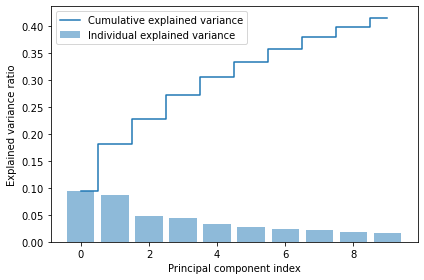

In [234]:
#plot it
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The bar chart above shows that only 40% of the total varience in the data is explained by the 10 projections combined.
This is not good enough. Therefore more projections should be used

In [235]:
#perform another PCA with the desired amount of explained variance as in input
pca = PCA(n_components=0.80)
X_reduced = pca.fit_transform(X)

In [236]:
X_reduced.shape

(89, 50)

In [237]:
X_reduced

array([[  17.70860267, -142.48255051,   71.35645414, ...,  -25.4081105 ,
         -32.66138478,   -9.30699483],
       [   9.42776679,  135.59467267,   24.34397585, ...,   -6.51660757,
          -3.95292722,  -10.2252957 ],
       [  71.87365232,  -28.82114366,    6.23077829, ...,  -18.79873567,
         -10.51055621,   -4.69198261],
       ...,
       [  28.65177934, -176.82115502,   18.04853867, ...,  -17.19195379,
          10.83691441,  -10.80893686],
       [ -12.24383476,  -46.04051986,  -57.68992429, ...,  -26.28809721,
           3.20523283,    7.93278456],
       [ -25.28674626,   75.0887873 ,   -9.3191181 , ...,  -31.8292519 ,
          -5.13751698,  -15.49793052]])

In [238]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

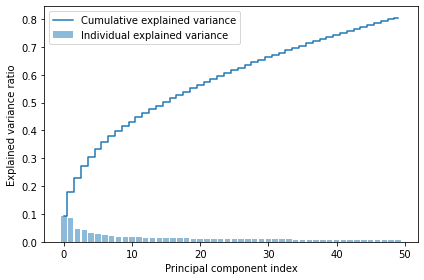

In [239]:
#plot it
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [240]:
#convert the pcs to dataframe
principalDf2 = pd.DataFrame(data = X_reduced)
principalDf2.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,17.708603,-142.482551,71.356454,34.404530,-22.466763,-1.437935,31.613070,-34.998552,-63.349876,-3.616282,...,-9.586099,22.142769,21.241542,-51.850784,9.146971,-0.769042,-13.493986,-25.408110,-32.661385,-9.306995
1,9.427767,135.594673,24.343976,94.266624,-37.595129,-62.458373,14.607622,7.642642,3.578621,50.475228,...,-6.094243,14.369108,-15.402477,-10.946513,10.961264,-9.388086,8.589024,-6.516608,-3.952927,-10.225296
2,71.873652,-28.821144,6.230778,23.805695,-4.869905,-18.417918,-45.752825,-73.987812,-86.988253,2.155451,...,-12.060732,-42.530506,-14.917703,-18.803210,-2.970997,-11.608137,-9.527144,-18.798736,-10.510556,-4.691983
3,-124.141653,-48.380200,-0.704334,150.936984,61.298933,24.440247,-17.146168,7.970175,-23.229551,12.636858,...,5.036325,-18.942354,-2.184873,3.628092,-46.124934,9.541196,29.139515,12.701867,30.319854,57.788715
4,62.639508,4.594828,37.473968,-38.705544,44.344389,9.536472,-51.381460,2.733682,16.631410,-28.377539,...,13.169215,29.014753,-13.634892,3.549916,1.854314,-22.640331,8.222850,-23.893245,-20.829910,-14.543401


Now close to 100% of the data is explained by 77 projections. This is still a lot. The plot also shows that about 80% of the variance can be captured by 55 projections which might a good option.

## LDA 
Now we try Linear Discreminate Analysis to see if we can further reduce the dimesnsions.


In [241]:
#concatenate the data
df = pd.concat([clinical_data, principalDf2], axis = 1)
df

,sample.name,source.location,characteristics.tag.gender,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.grade,label,0,...,40,41,42,43,44,45,46,47,48,49
0,LUNG3-01,Left Lower Lobe,M,4.0,pT2,pN0,pM0,3,1,17.708603,...,-9.586099,22.142769,21.241542,-51.850784,9.146971,-0.769042,-13.493986,-25.408110,-32.661385,-9.306995
1,LUNG3-02,Left Lower Lobe,M,1.3,pT1,pNX,pMX,5,2,9.427767,...,-6.094243,14.369108,-15.402477,-10.946513,10.961264,-9.388086,8.589024,-6.516608,-3.952927,-10.225296
2,LUNG3-03,Left Lower Lobe,M,11.0,pT3,pN0,pM0,3,3,71.873652,...,-12.060732,-42.530506,-14.917703,-18.803210,-2.970997,-11.608137,-9.527144,-18.798736,-10.510556,-4.691983
3,LUNG3-04,Left Lower Lobe,M,NaN,pTX,pNX,pM1,5,3,-124.141653,...,5.036325,-18.942354,-2.184873,3.628092,-46.124934,9.541196,29.139515,12.701867,30.319854,57.788715
4,LUNG3-05,Left Lower Lobe,F,7.8,pT3,pN0,pM0,2,1,62.639508,...,13.169215,29.014753,-13.634892,3.549916,1.854314,-22.640331,8.222850,-23.893245,-20.829910,-14.543401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,LUNG3-85,Right Upper Lobe,M,2.2,pT1b,pN0,pM0,5,2,-63.392396,...,9.109298,12.517870,2.911964,5.306657,6.631124,-35.882176,-34.777740,34.239491,-0.240221,-39.891768
85,LUNG3-86,Right Upper Lobe,M,5.0,pT3,PN2,pM0,3,1,26.004943,...,8.226067,3.291113,-16.682503,-37.427363,-22.407540,1.727048,44.385961,0.339431,28.245298,-37.126121
86,LUNG3-87,Right Middle Lobe,M,3.5,pT2,pN0,pM0,2,1,28.651779,...,-11.201803,-0.969344,7.742076,3.187336,-9.081289,-14.982744,-5.644312,-17.191954,10.836914,-10.808937
87,LUNG3-88,Right Upper Lobe,M,8.5,pT3,pN0,pM0,5,3,-12.243835,...,20.925373,-6.779041,-14.100947,-9.955594,10.231220,-8.912607,-13.681507,-26.288097,3.205233,7.932785


In [242]:
df.head()

,sample.name,source.location,characteristics.tag.gender,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.grade,label,0,...,40,41,42,43,44,45,46,47,48,49
0,LUNG3-01,Left Lower Lobe,M,4.0,pT2,pN0,pM0,3,1,17.708603,...,-9.586099,22.142769,21.241542,-51.850784,9.146971,-0.769042,-13.493986,-25.408110,-32.661385,-9.306995
1,LUNG3-02,Left Lower Lobe,M,1.3,pT1,pNX,pMX,5,2,9.427767,...,-6.094243,14.369108,-15.402477,-10.946513,10.961264,-9.388086,8.589024,-6.516608,-3.952927,-10.225296
2,LUNG3-03,Left Lower Lobe,M,11.0,pT3,pN0,pM0,3,3,71.873652,...,-12.060732,-42.530506,-14.917703,-18.803210,-2.970997,-11.608137,-9.527144,-18.798736,-10.510556,-4.691983
3,LUNG3-04,Left Lower Lobe,M,NaN,pTX,pNX,pM1,5,3,-124.141653,...,5.036325,-18.942354,-2.184873,3.628092,-46.124934,9.541196,29.139515,12.701867,30.319854,57.788715
4,LUNG3-05,Left Lower Lobe,F,7.8,pT3,pN0,pM0,2,1,62.639508,...,13.169215,29.014753,-13.634892,3.549916,1.854314,-22.640331,8.222850,-23.893245,-20.829910,-14.543401


## Plot the PCA 
Noe we plot the PCA projections to see if we can identify any clusters(s)

In [243]:
plt.scatter(df['pc1'], df['pc2'], c = df['characteristics.tag.grade'], cmap = "jet", edgecolor = "None", alpha=0.35)
plt.title('Actual clusters using PC1 and PC2')
plt.show()


plt.scatter(df['pc1'], df['pc3'], c = df['characteristics.tag.grade'], cmap = "jet", edgecolor = "None", alpha=0.35)
plt.title('Actual clusters using PC2 and PC3')
plt.show()

plt.plot(pca.explained_variance_ratio_)
plt.title('Explained variance (ratio)')
plt.show()

KeyError: 'pc1'

TSNE

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
Y = tsne.fit_transform(X_reduced)

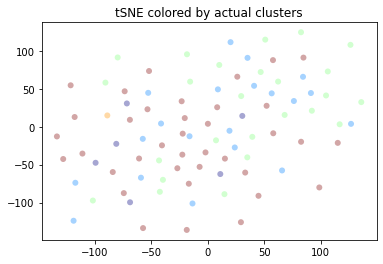

In [ ]:
plt.scatter(Y[:,0],Y[:,1],  c = clinical_data['characteristics.tag.grade'], cmap = "jet", edgecolor = "None", alpha=0.35)
plt.title('tSNE colored by actual clusters')
plt.show()

[]

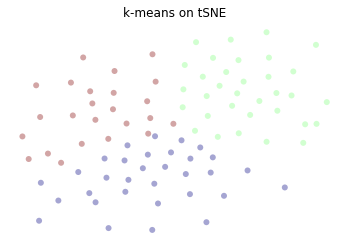

In [ ]:
from sklearn.cluster import KMeans
# K-means on tSNE results
kmns = KMeans(n_clusters=3, init='k-means++')
kY = kmns.fit_predict(Y)

plt.scatter(Y[:,0],Y[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
plt.title('k-means on tSNE')
plt.axis('off')
plt.plot()

In [244]:
from sklearn import metrics
k_means_ev = metrics.adjusted_rand_score(kmns.labels_, clinical_data['label'])

print('Adjusted clustering score kmeans on PCs to cover 85% of variance for regrouped labels: {:0.3f}'.format(k_means_ev))

Adjusted clustering score kmeans on PCs to cover 85% of variance for regrouped labels: 0.328


(-147.07015380859374,
 149.52184448242187,
 -149.17450294494628,
 137.6403003692627)

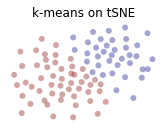

In [246]:
# K-means on tSNE results
kmns = KMeans(n_clusters=2, init='k-means++')
kY = kmns.fit_predict(Y)

plt.subplot(222)
plt.scatter(Y[:,0],Y[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
plt.title('k-means on tSNE')
plt.axis('off')

In [247]:
k_means_ev = metrics.adjusted_rand_score(kmns.labels_, clinical_data['label'])

print('Adjusted clustering score kmeans on PCs to cover 85% of variance for regrouped labels: {:0.3f}'.format(k_means_ev))

Adjusted clustering score kmeans on PCs to cover 85% of variance for regrouped labels: 0.435


TSNe also shows no separation of the data. 

## Spectral Clustering

In [252]:
#first we do spectral embedding and color by label to see the number of clusters present
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=4)
X_transformed = embedding.fit_transform(X_reduced)
X_transformed.shape



(89, 4)

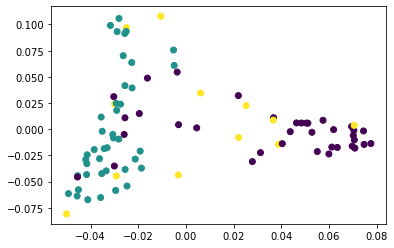

In [253]:
#plot
plt.scatter(X_transformed[:,0], X_transformed[:,1],c = clinical_data['label'] )
plt.show()

The clusters not show good separation

In [259]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=2).fit(X_reduced)
print(sc)

SpectralClustering(n_clusters=2)


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


The accuracy is horrible and the model is a bad option.

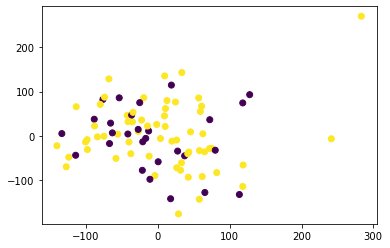

In [260]:
#plot
labels = sc.labels_

plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels)
plt.show()  

In [261]:
k_means_ev = metrics.adjusted_rand_score(labels, clinical_data['label'])

print('Adjusted clustering score kmeans on PCs to cover 85% of variance for regrouped labels: {:0.3f}'.format(k_means_ev))

Adjusted clustering score kmeans on PCs to cover 85% of variance for regrouped labels: -0.018
